In [1]:
import numpy as np
import matplotlib.pyplot as ply
import os
import time
#from keras.layers import Dense, Dropout, Flatten, Conv2D, Conv3D
#from keras.layers import Reshape, Conv2DTranspose, LeakyReLU, concatenate
import tensorflow as tf
import sys

Using TensorFlow backend.


In [2]:
tfgan = tf.contrib.gan
tf.reset_default_graph()

In [3]:
sys.path.append('gans_utils/gans')
from generators import encoder_decoder_generator
from discriminators import basic_discriminator
from gan_utils import visualize_training_generator, dataset_to_stream, parse_img_dir

In [4]:
output_height = 64
output_width = 64
batch_size = 32
max_epochs = 50
image_to_visualize = 6

train_dir = 'cityscapes_data/train'
left_img_provider, right_img_provider = parse_img_dir(train_dir, output_height, 
                                                      output_width, batch_size, max_epochs)

# Validation data
val_dir = 'cityscapes_data/val'
val_left_img_provider, val_right_img_provider = parse_img_dir(val_dir, output_height, 
                                                              output_width, batch_size, 
                                                              max_epochs)

Instructions for updating:
Use `tf.data.Dataset.batch(..., drop_remainder=True)`.


In [5]:
# Build the genrator and discriminator
gan_model = tfgan.gan_model(generator_fn = encoder_decoder_generator,
                           discriminator_fn = basic_discriminator,
                           real_data = left_img_provider,
                           generator_inputs = right_img_provider)

In [6]:
# build the GAN loss and standard pixel loss
gan_loss = tfgan.gan_loss(gan_model,
                         generator_loss_fn = tfgan.losses.wasserstein_generator_loss,
                         discriminator_loss_fn = tfgan.losses.wasserstein_discriminator_loss,
                         gradient_penalty_weight = 1.0)
l1_pixel_loss = tf.norm(gan_model.real_data-gan_model.generator_inputs, ord = 1)

# Modify the loss tuple to include the pixel loss.
gan_loss = tfgan.losses.combine_adversarial_loss(gan_loss, gan_model, 
                                                 l1_pixel_loss, gradient_ratio=1)

In [7]:
# Optimizer
generator_optimizer = tf.train.AdamOptimizer(0.001, beta1 = 0.5)
discriminator_optimizer = tf.train.AdamOptimizer(0.001, beta1=0.5)
gan_train_ops = tfgan.gan_train_ops(gan_model,
                                gan_loss,
                                generator_optimizer,
                                discriminator_optimizer)

In [8]:
# Set up Visualization
with tf.variable_scope('Generator', reuse = True):
    eval_images = gan_model.generator_fn(right_img_provider)

# What are these?
reshaped_cond_val_images = tfgan.eval.image_reshaper(val_right_img_provider[:image_to_visualize,...], num_cols = 1)
reshaped_gen_imgs = tfgan.eval.image_reshaper(eval_images[:image_to_visualize, ...], num_cols=1)
reshaped_goal_val_images = tfgan.eval.image_reshaper(val_left_img_provider[:image_to_visualize, ...], num_cols=1)

In [9]:
g_d_updates_per_step = tfgan.GANTrainSteps(1,2) # do 1 gen step, then 2 disc steps
train_step_fn = tfgan.get_sequential_train_steps(g_d_updates_per_step) #default is 1:1 ratio

global_step = tf.train.get_or_create_global_step()

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Training step: 0
Time since start: 0.101223 m
Steps per min: 0.000000


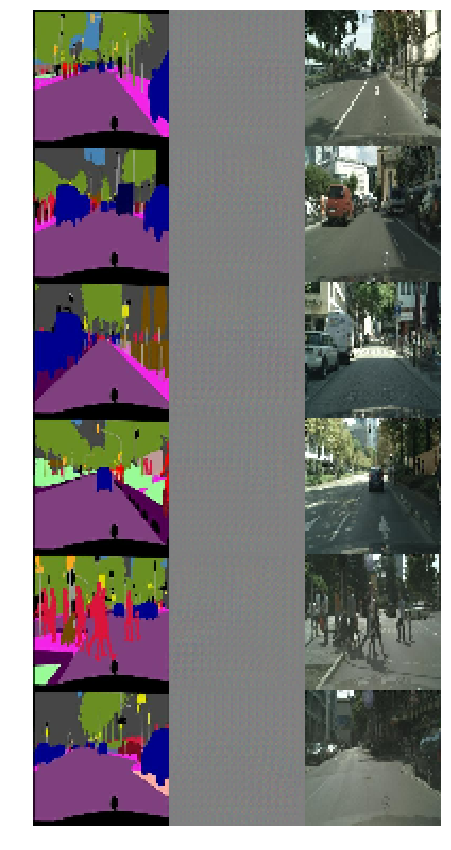

Training step: 100
Time since start: 6.990767 m
Steps per min: 14.304583


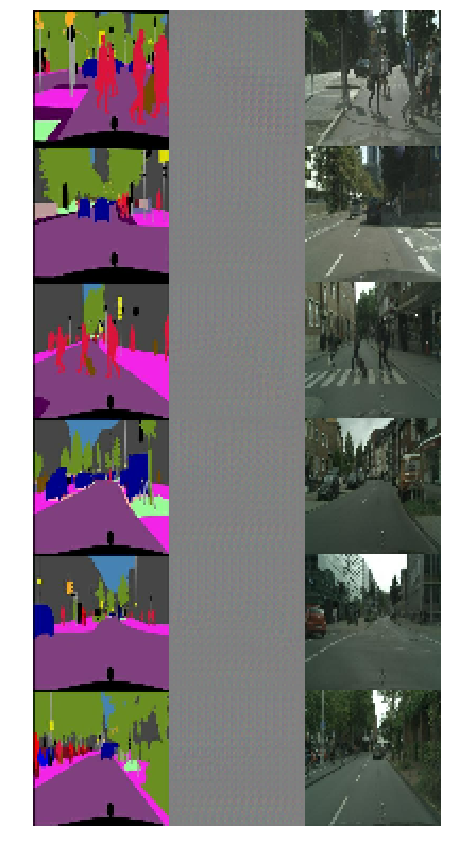

Training step: 200
Time since start: 13.523528 m
Steps per min: 14.789040


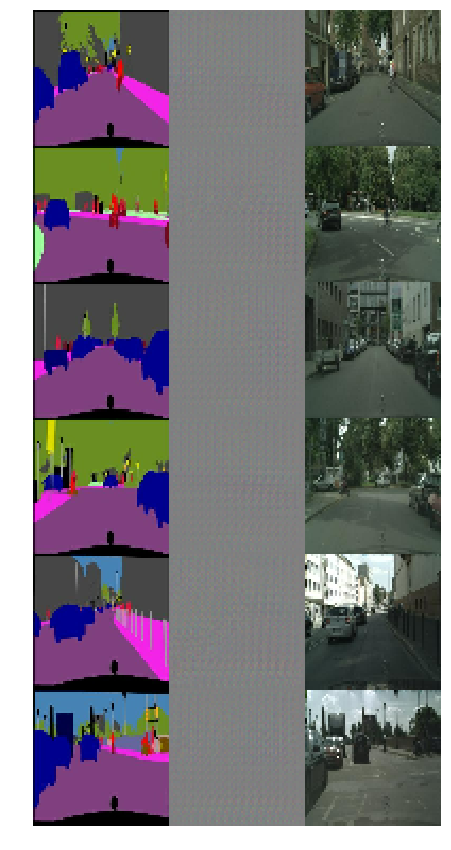

Training step: 300
Time since start: 20.055960 m
Steps per min: 14.958147


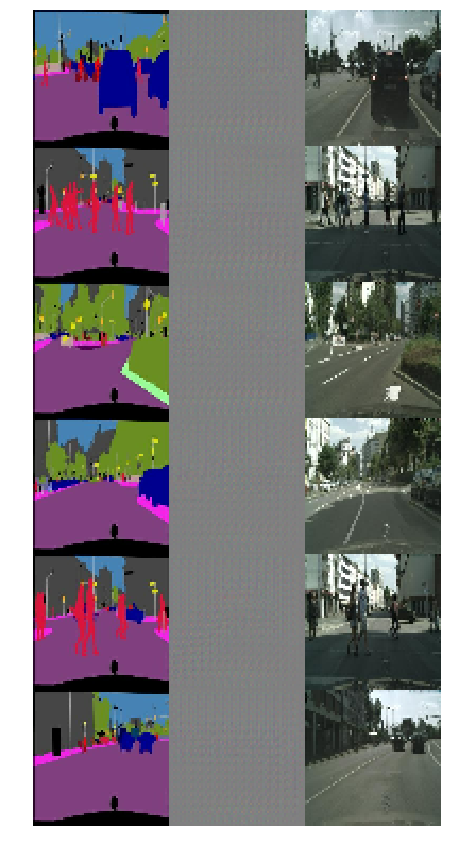

Training step: 400
Time since start: 26.529644 m
Steps per min: 15.077473


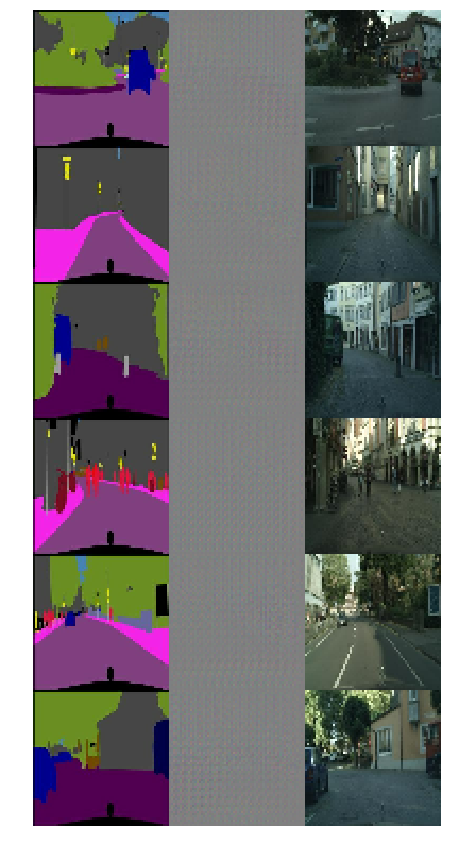

Training step: 500
Time since start: 33.015683 m
Steps per min: 15.144318


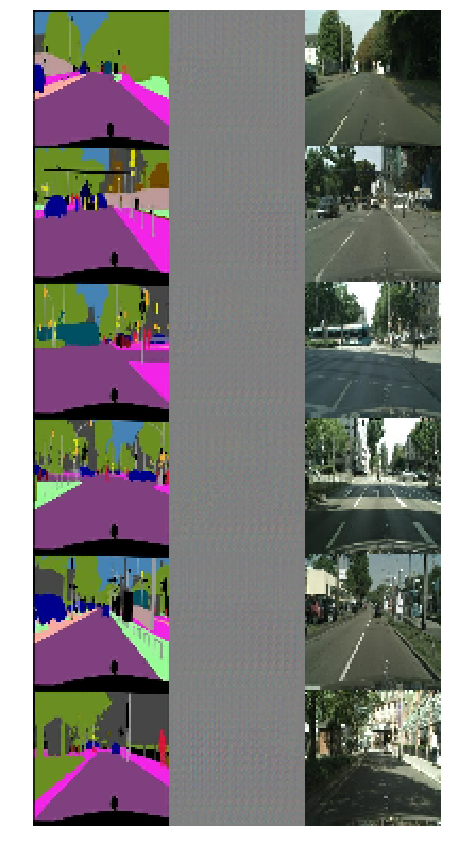

Training step: 600
Time since start: 39.521133 m
Steps per min: 15.181751


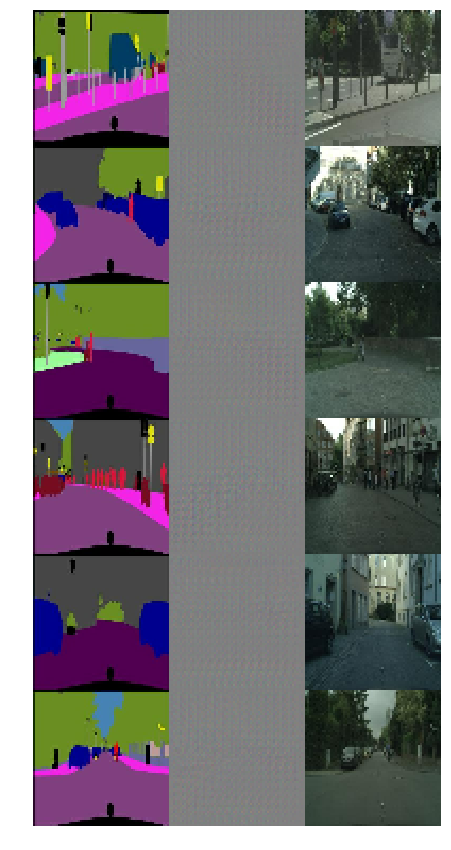

Training step: 700
Time since start: 46.000627 m
Steps per min: 15.217184


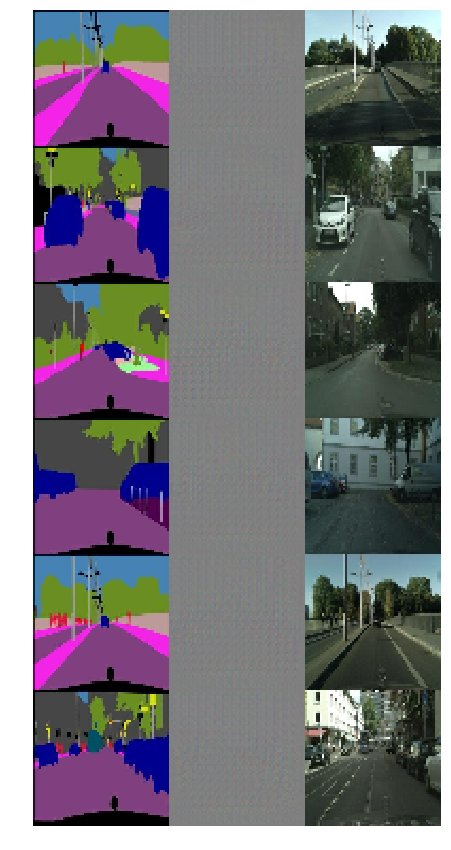

Training step: 800
Time since start: 52.421079 m
Steps per min: 15.261036


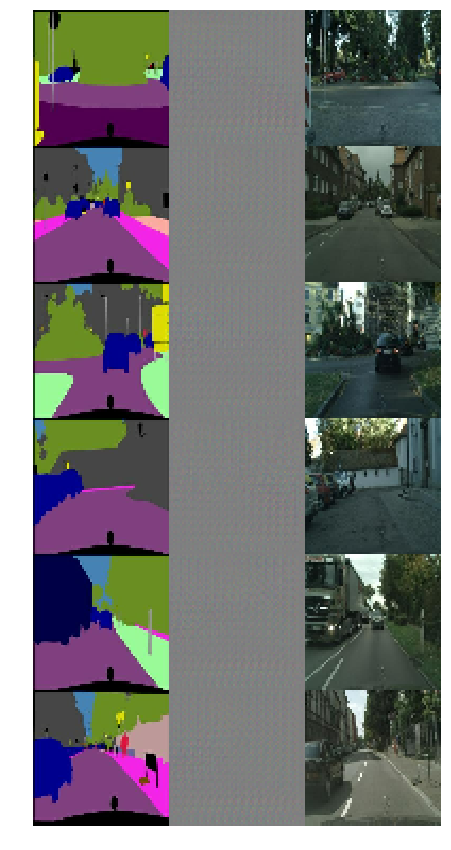

Training step: 900
Time since start: 58.675828 m
Steps per min: 15.338514


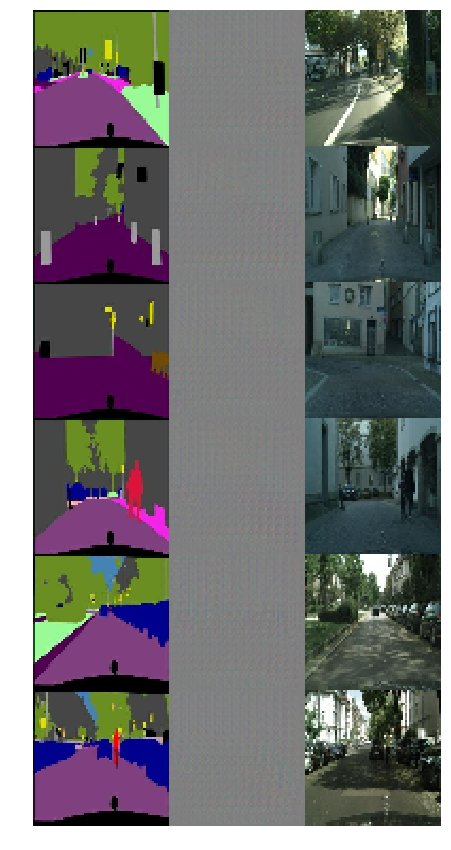

Training step: 1000
Time since start: 64.871533 m
Steps per min: 15.415082


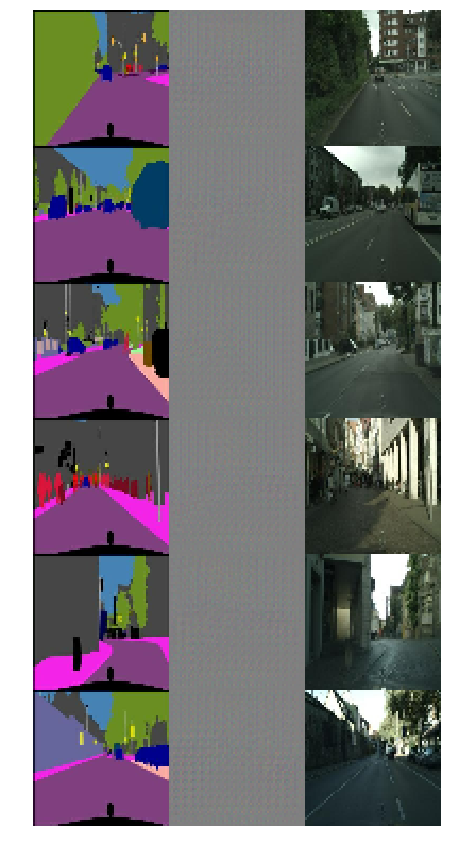

Training step: 1100
Time since start: 71.027302 m
Steps per min: 15.487002


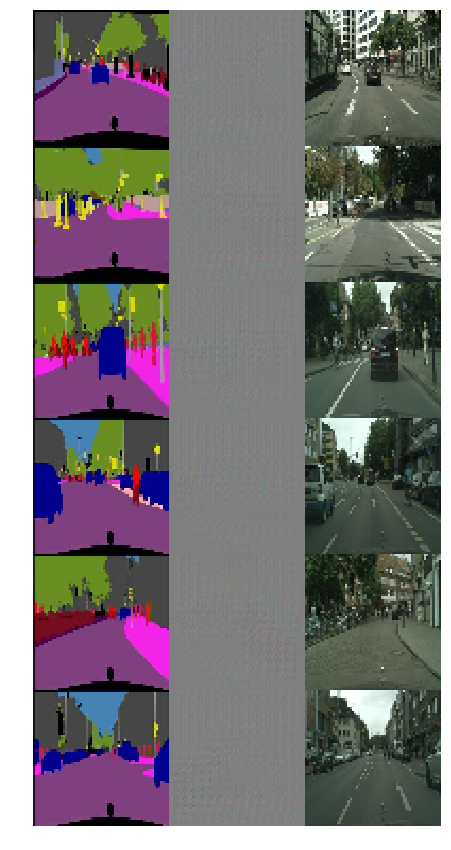

Training step: 1200
Time since start: 77.214847 m
Steps per min: 15.541053


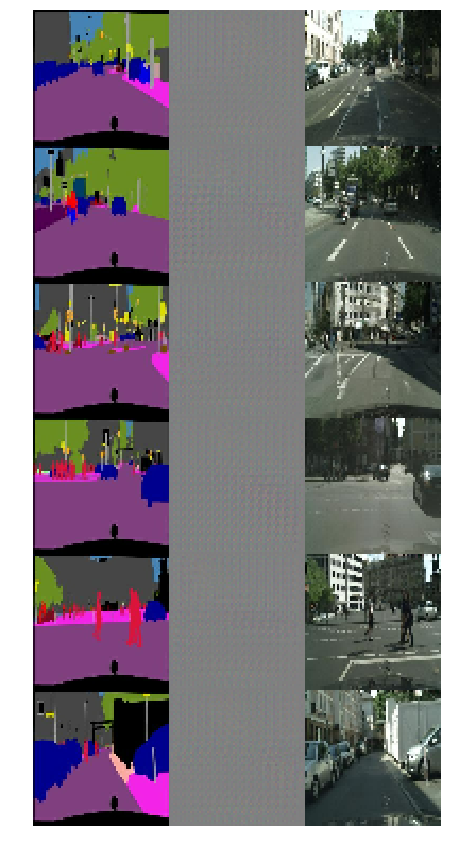

Training step: 1300
Time since start: 83.429165 m
Steps per min: 15.582081


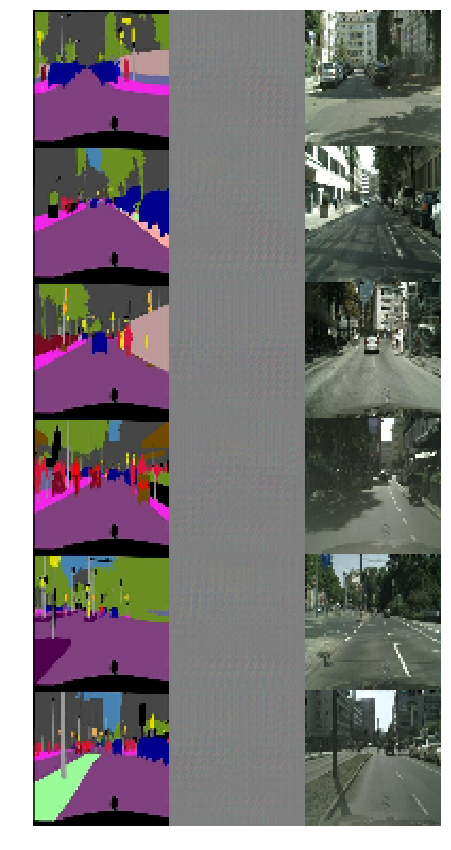

Training step: 1400
Time since start: 89.699975 m
Steps per min: 15.607585


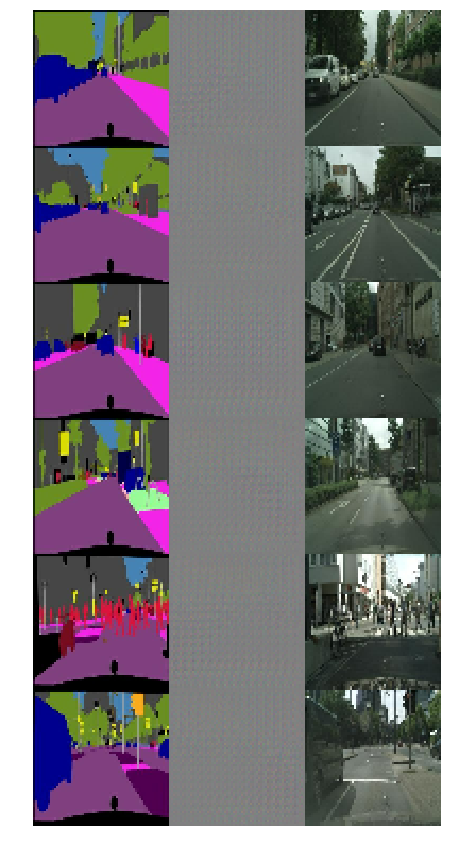

Training step: 1500
Time since start: 95.960415 m
Steps per min: 15.631445


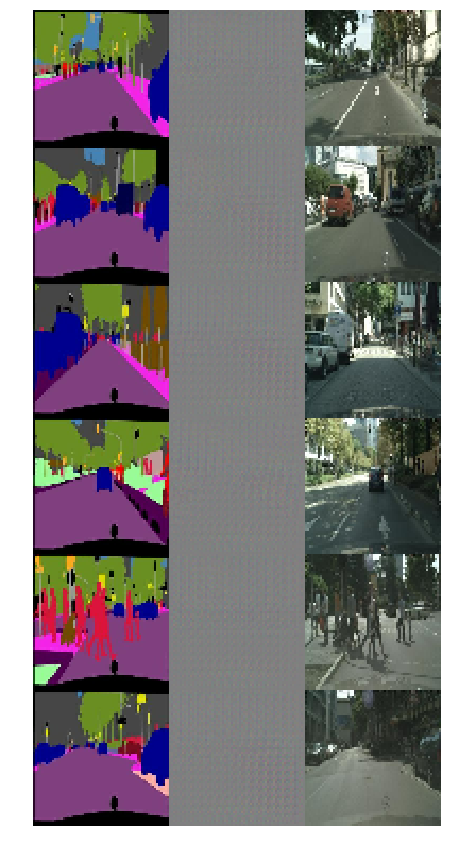

Training step: 1600
Time since start: 102.226063 m
Steps per min: 15.651586


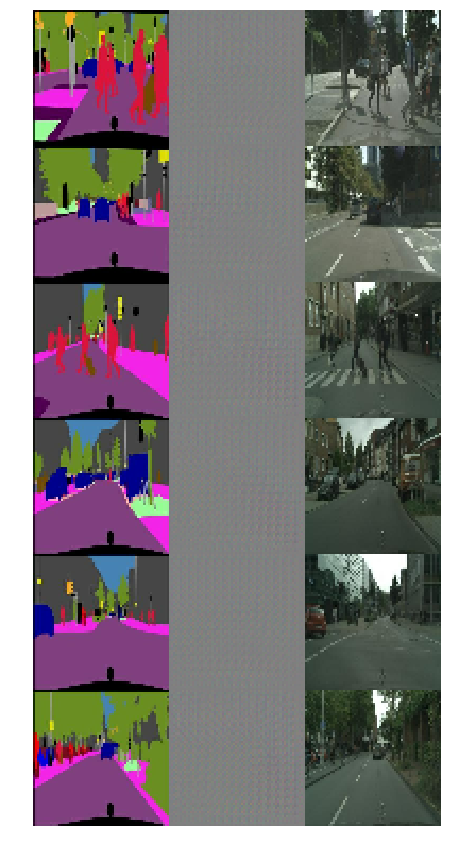

Training step: 1700
Time since start: 108.503360 m
Steps per min: 15.667718


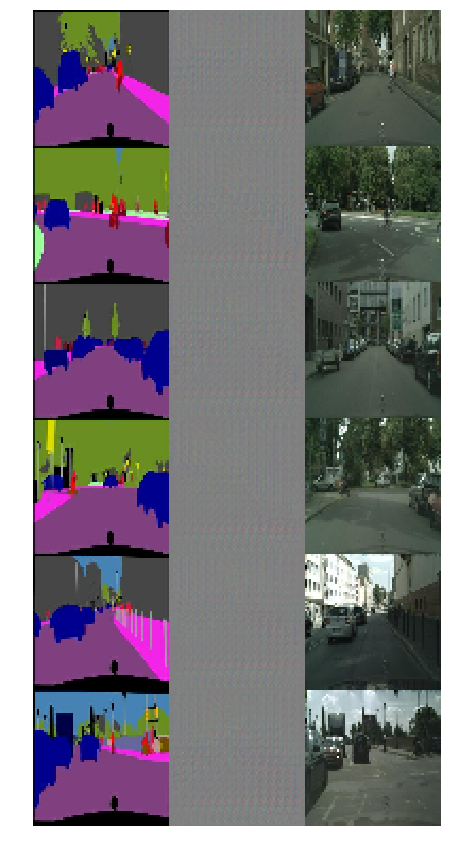

Training step: 1800
Time since start: 114.782504 m
Steps per min: 15.681833


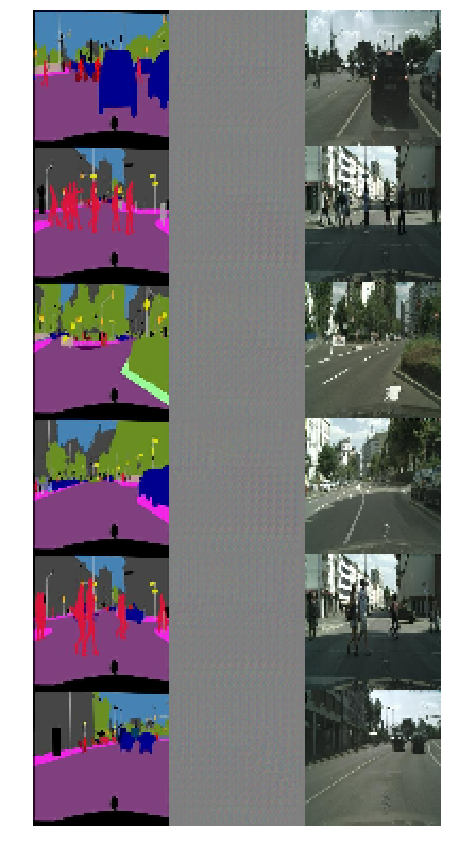

Training step: 1900
Time since start: 121.033612 m
Steps per min: 15.698119


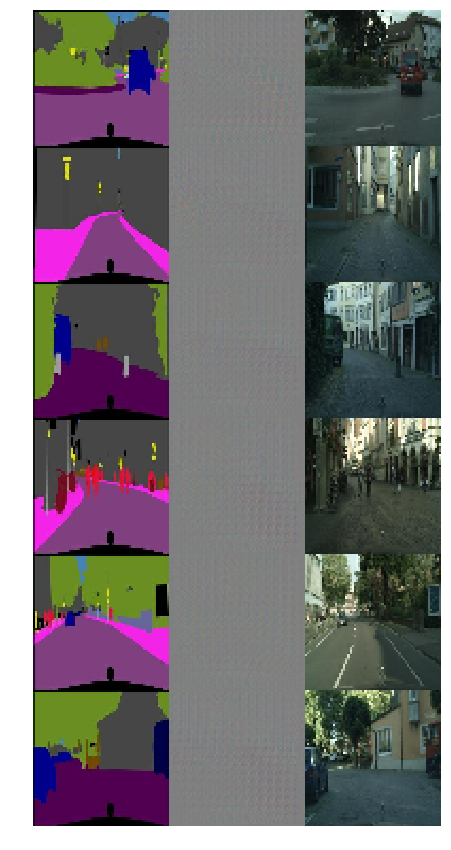

Training step: 2000
Time since start: 127.378015 m
Steps per min: 15.701297


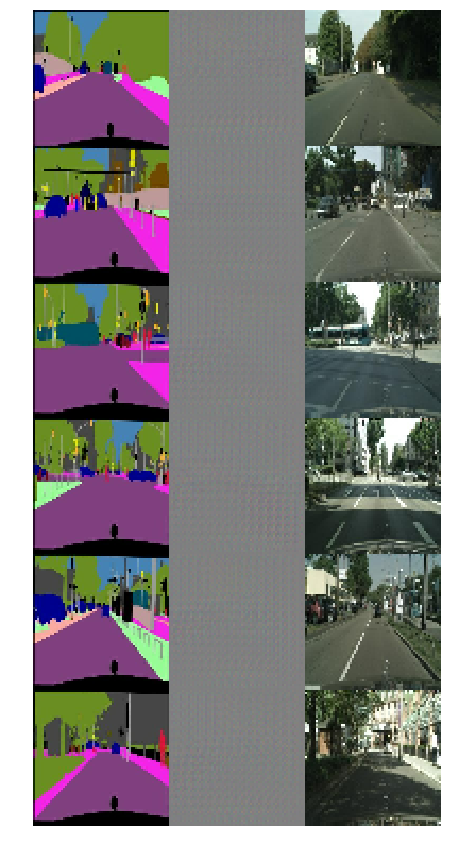

Training step: 2100
Time since start: 133.658042 m
Steps per min: 15.711737


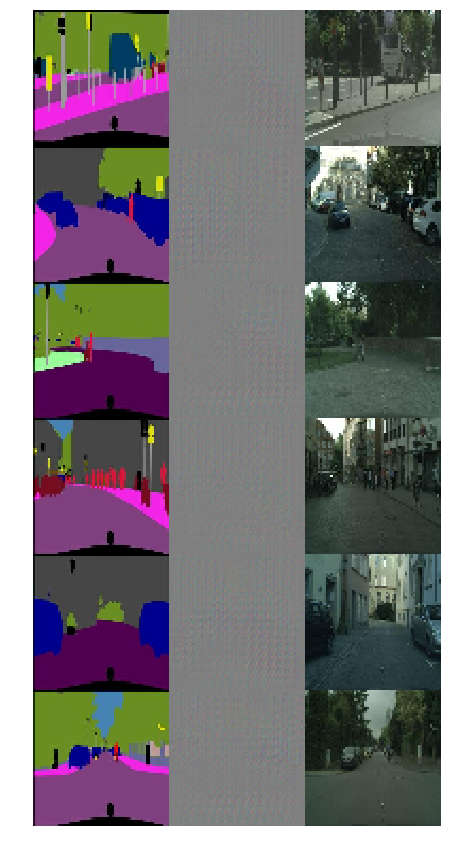

Training step: 2200
Time since start: 139.925242 m
Steps per min: 15.722681


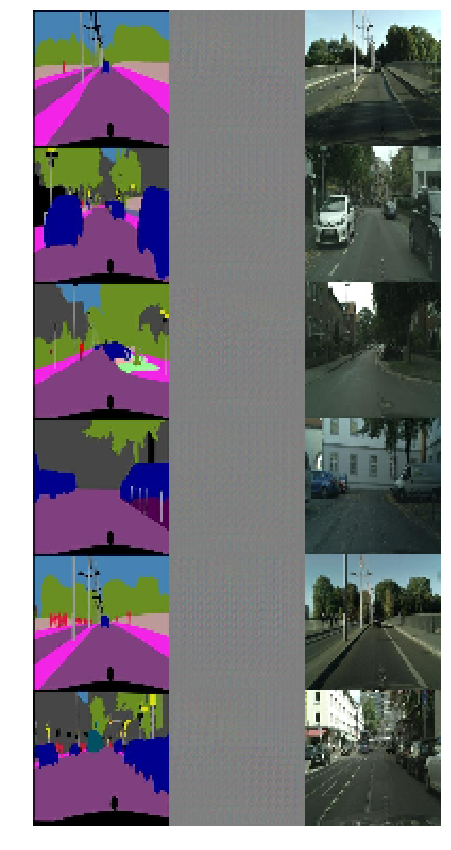

Training step: 2300
Time since start: 146.195449 m
Steps per min: 15.732364


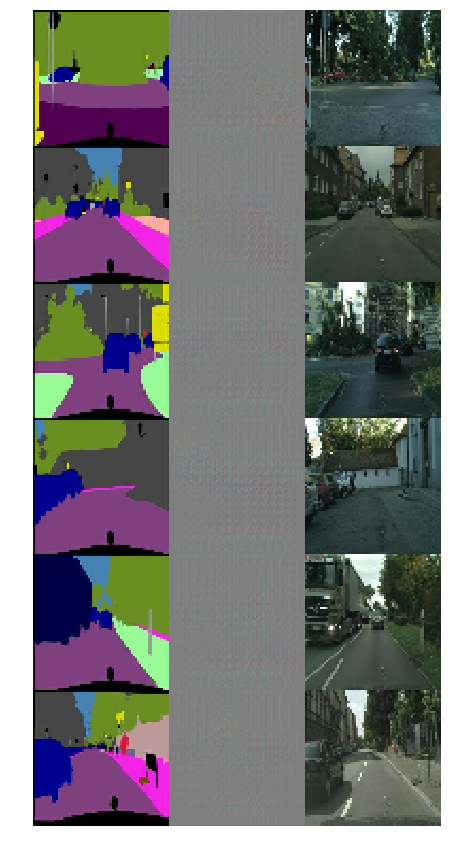

Training step: 2400
Time since start: 152.646072 m
Steps per min: 15.722645


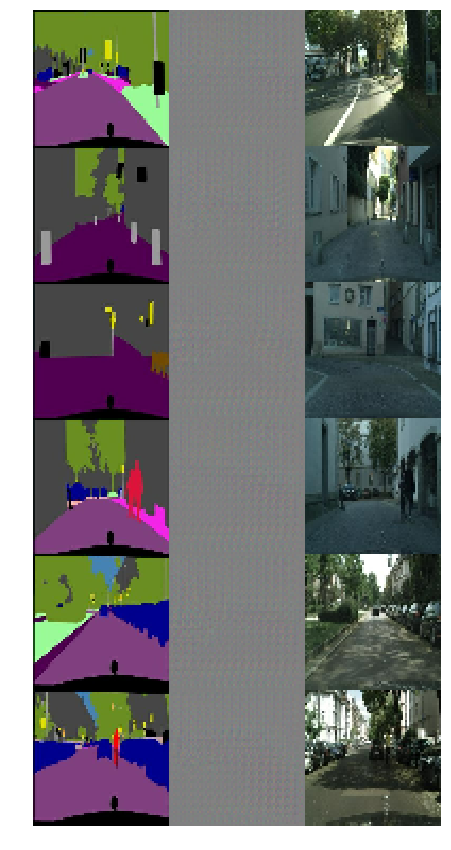

Training step: 2500
Time since start: 158.949251 m
Steps per min: 15.728291


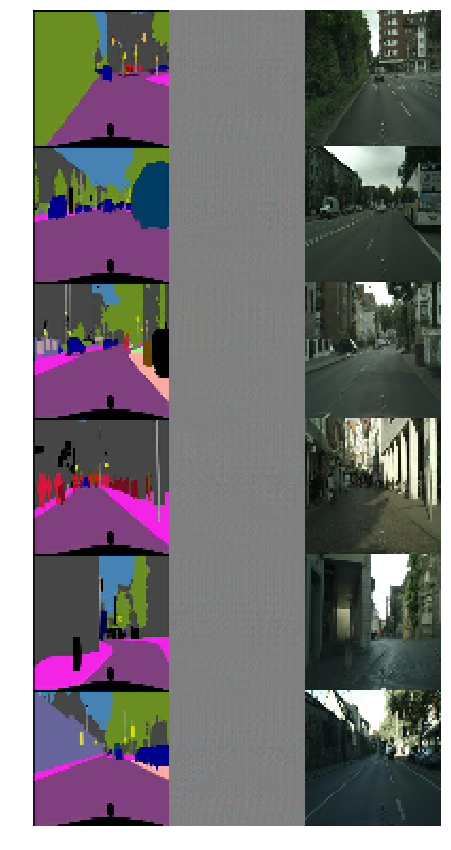

KeyboardInterrupt: 

In [10]:
num_steps = 3001
with tf.train.SingularMonitoredSession() as sess:
    start_time = time.time()
    for i in range(num_steps):
        loss, done_training = train_step_fn(sess, gan_train_ops, global_step, 
                                            train_step_kwargs = {})
        if i % 100 == 0:
            plottables = sess.run([reshaped_cond_val_images, reshaped_gen_imgs, 
                                   reshaped_goal_val_images])
            visualize_training_generator(i, start_time, plottables, undo_normalization = True)